In [1]:
from sklearn.svm import SVR, LinearSVR
import pandas as pd
import numpy as np
import matplotlib
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut, GridSearchCV
from sklearn import preprocessing
import seaborn as sns
import scipy.stats as stats
import scipy.io as sio
import sklearn
import sys
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import pearsonr, spearmanr, permutation_test # need python3.8
import warnings
from pycirclize import Circos
warnings.filterwarnings('ignore')

In [2]:
def compute_statistic(x, y):
    return stats.pearsonr(x, y)[0]

In [3]:
# Load data
featurepath='/media/shuang/data/BrainAge/Brain_age_scripts/network_features/'
hc_fc_data = pd.read_csv(featurepath+'FC_HC_mean.csv', header=None)
hc_sc_data = pd.read_csv(featurepath+'SC_HC_mean.csv', header=None)
hc_msn_data = pd.read_csv(featurepath+'MSN_HC_mean.csv', header=None)
hc_age_data = pd.read_excel('/media/shuang/data/BrainAge/Brain_age_scripts/data/HC_age.xlsx')
eos_fc_data = pd.read_csv(featurepath+'FC_EOS_mean.csv', header=None)
eos_sc_data = pd.read_csv(featurepath+'SC_EOS_mean.csv', header=None)
eos_msn_data = pd.read_csv(featurepath+'MSN_EOS_mean.csv', header=None)
eos_age_data = pd.read_excel('/media/shuang/data/BrainAge/Brain_age_scripts/data/EOS_age.xlsx')

hc_fc_data = np.array(hc_fc_data.iloc[2:, :])
hc_sc_data = np.array(hc_sc_data.iloc[2:, :])
hc_msn_data = np.array(hc_msn_data.iloc[2:, :])
hc_age_data = np.array(hc_age_data)
eos_fc_data = np.array(eos_fc_data.iloc[2:, :])
eos_sc_data = np.array(eos_sc_data.iloc[2:, :])
eos_msn_data = np.array(eos_msn_data.iloc[2:, :])
eos_age_data = np.array(eos_age_data)

In [5]:
# Choose one modal data
hc_data = hc_msn_data
eos_data = eos_msn_data

In [6]:
# Normalized data
y_hc = hc_age_data[:, 0]
y_eos = eos_age_data[:, 0]
min_max_scaler = preprocessing.StandardScaler()
min_max_scaler = min_max_scaler.fit(hc_data) # fit training set
x_hc = min_max_scaler.transform(hc_data) 
x_eos = min_max_scaler.transform(eos_data)
t_value = stats.ttest_ind(x_hc,x_eos)
t_value = t_value.statistic
print(x_hc.shape, x_eos.shape)

(91, 253) (80, 253)


In [7]:
# Select features
select_id = sio.loadmat('/media/shuang/data/BrainAge/Brain_age_scripts/output/FeaturesS_MSN_RF.mat')['saved_msnidx'][0, :]
print(len(select_id))

36


In [8]:
# Predicting
y_pred_hc = np.zeros((y_hc.shape[0]))
# repeat 50 times; 10 fold cv
num_folds = 10
num_repeats = 50
num_models = 8
all_y_pred_hc = np.zeros((num_repeats, num_models, y_hc.shape[0]))
all_y_pred_eos = np.zeros((num_repeats, num_folds, num_models , y_eos.shape[0]))
coef = np.zeros((num_repeats, num_folds, x_hc.shape[1]))
count = 0
for repeat in range(num_repeats):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=repeat)
    k = 0
    print(count)
    for train_index, test_index in kf.split(x_hc):
        X_train, X_test = x_hc[train_index], x_hc[test_index]
        y_train, y_test = y_hc[train_index], y_hc[test_index] 
        
        # Select features survive REFCV
        select_index = select_id
        X_train = np.array(X_train)[:,select_index]
        X_test = np.array(X_test)[:,select_index]
        
        for e,estimator in enumerate([SVR(),
                                      ElasticNet(), Ridge(), Lasso(), LinearRegression(),
                                      DecisionTreeRegressor(), RandomForestRegressor(), KNeighborsRegressor(),
                                     ]):
            if type(estimator) is SVR:
                param_grid = {'C': [0.0001, 0.001, 0.005, 0.01, 0.1, 1.0], 'kernel': ('linear','poly','rbf','sigmoid')}
                grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                grid_search.fit(X_train, y_train)
                # predicting test data of HC
                best_model = grid_search.best_estimator_
                print(grid_search.best_params_)
            elif type(estimator) is ElasticNet:
                param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0], 'l1_ratio': np.linspace(0.1,1,10)}
                grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                grid_search.fit(X_train, y_train)
                # predicting test data of HC
                best_model = grid_search.best_estimator_
                print(grid_search.best_params_)
            elif type(estimator) in (Ridge,Lasso):
                param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}
                grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                grid_search.fit(X_train, y_train)
                # predicting test data of HC
                best_model = grid_search.best_estimator_
                print(grid_search.best_params_)
            elif type(estimator) is DecisionTreeRegressor:
                param_grid = {"max_depth":np.linspace(8,16,1, dtype=int),'min_samples_split': [2,4,6],'min_samples_leaf':[1,2,4]}
                grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                print(grid_search.best_params_)
            elif type(estimator) is RandomForestRegressor:
                param_grid={"n_estimators":np.linspace(50,400,50, dtype=int),"max_depth":np.linspace(8,16,2, dtype=int)}
                grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                print(grid_search.best_params_)
            elif type(estimator) is KNeighborsRegressor:
                param_grid = [{'weights': ['uniform'],'n_neighbors': [i for i in range(1, 11)]},
                              {'weights': ['distance'],'n_neighbors': [i for i in range(1, 11)],'p': [i for i in range(1, 6)]}]
                grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                print(grid_search.best_params_)
            else:
                best_model = estimator.fit(X_train, y_train)   
            y_pred_hc = best_model.predict(X_test)
            print(y_pred_hc.shape)
            all_y_pred_hc[repeat, e, test_index] = y_pred_hc
            # predicting EOS data
            x_eos_sf = np.array(x_eos)[:,select_index] # selected features
            y_pred_eos = best_model.predict(x_eos_sf)
            all_y_pred_eos[repeat, k, e, :] = y_pred_eos
        k = k + 1
        count = count + 1

0
{'C': 0.1, 'kernel': 'linear'}
(10,)
{'alpha': 0.1, 'l1_ratio': 0.7000000000000001}
(10,)
{'alpha': 10.0}
(10,)
{'alpha': 0.1}
(10,)
(10,)
{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 4}
(10,)
{'max_depth': 16, 'n_estimators': 71}
(10,)
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
(10,)
{'C': 0.1, 'kernel': 'linear'}
(9,)
{'alpha': 0.1, 'l1_ratio': 0.4}
(9,)
{'alpha': 10.0}
(9,)
{'alpha': 0.1}
(9,)
(9,)
{'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2}
(9,)
{'max_depth': 16, 'n_estimators': 135}
(9,)
{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
(9,)
{'C': 1.0, 'kernel': 'sigmoid'}
(9,)
{'alpha': 0.1, 'l1_ratio': 0.7000000000000001}
(9,)
{'alpha': 10.0}
(9,)
{'alpha': 0.1}
(9,)
(9,)
{'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 4}
(9,)
{'max_depth': 8, 'n_estimators': 50}
(9,)
{'n_neighbors': 7, 'weights': 'uniform'}
(9,)
{'C': 1.0, 'kernel': 'sigmoid'}
(9,)
{'alpha': 0.1, 'l1_ratio': 1.0}
(9,)
{'alpha': 10.0}
(9,)
{'alpha': 0.1}


In [28]:
# permutation test for r values: takes long time
y_pred_eos_50 = np.mean(all_y_pred_eos, axis=1)
HC_pearson_perm = np.zeros((all_y_pred_hc.shape[0],2,num_models))
EOS_pearson_perm = np.zeros((all_y_pred_hc.shape[0],2,num_models))
HC_MAE = np.zeros((all_y_pred_hc.shape[0],num_models))
EOS_MAE = np.zeros((all_y_pred_hc.shape[0],num_models))
HC_R2 = np.zeros((all_y_pred_hc.shape[0],num_models))
EOS_R2 = np.zeros((all_y_pred_hc.shape[0],num_models))
for i in range(all_y_pred_hc.shape[0]):
    for j in range(y_pred_eos_50.shape[1]):
        temp = permutation_test((y_hc, all_y_pred_hc[i,j,:]), compute_statistic, permutation_type='independent', alternative='two-sided', n_resamples=5000, random_state=42)
        HC_pearson_perm[i,0,j] = temp.statistic
        HC_pearson_perm[i,1,j] = temp.pvalue
        temp = permutation_test((y_eos, y_pred_eos_50[i,j,:]), compute_statistic, permutation_type='independent', alternative='two-sided', n_resamples=5000, random_state=42)
        EOS_pearson_perm[i,0,j] = temp.statistic
        EOS_pearson_perm[i,1,j] = temp.pvalue
        HC_MAE[i,j] = sklearn.metrics.mean_absolute_error(y_hc, all_y_pred_hc[i,j,:])
        EOS_MAE[i,j] = sklearn.metrics.mean_absolute_error(y_eos, y_pred_eos_50[i,j,:])
        HC_R2[i,j] = sklearn.metrics.r2_score(y_hc, all_y_pred_hc[i,j,:])
        EOS_R2[i,j] = sklearn.metrics.r2_score(y_eos, y_pred_eos_50[i,j,:])

In [13]:
print(' Mean r value between brain age and chronological age: ', np.nanmean(EOS_pearson_perm[:,0,6]))
print('Standard Deviations of r value between brain age and chronological age: ', np.nanstd(EOS_pearson_perm[:,0,6]))

 Mean r value between brain age and chronological age:  0.3066777233525093
Standard Deviations of r value between brain age and chronological age:  0.009594797046147591


In [16]:
# How many times significant for r values
sigmodel = np.zeros((num_models,2))
for j in range(num_models):
    sigmodel[j,0]=sum(sigf < 0.05 for sigf in HC_pearson_perm[:,1,j])
    sigmodel[j,1]=sum(sigf < 0.05 for sigf in EOS_pearson_perm[:,1,j])
pd.DataFrame(sigmodel)

,0,1
0,50.0,0.0
1,50.0,0.0
2,50.0,0.0
3,50.0,0.0
4,50.0,0.0
5,50.0,36.0
6,50.0,50.0
7,50.0,50.0


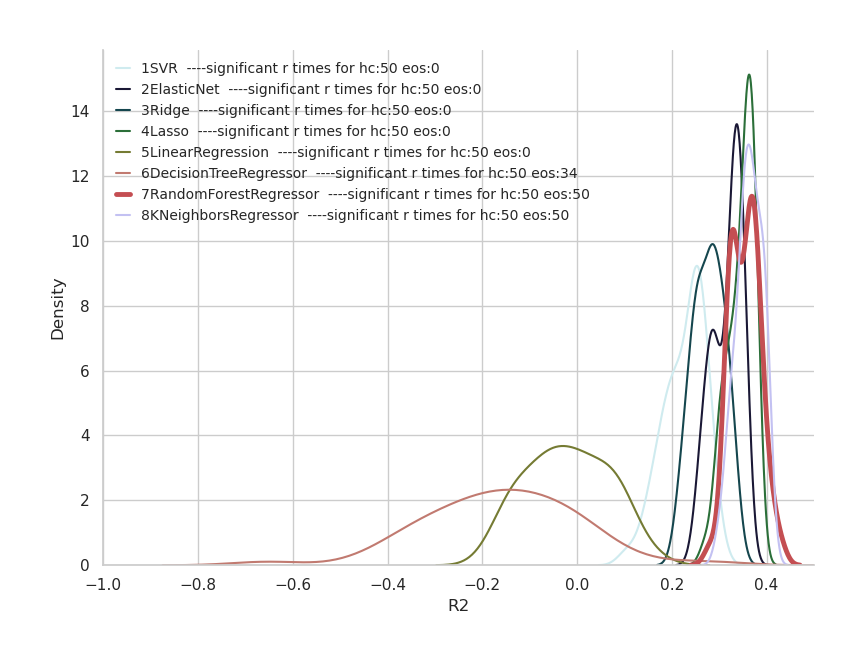

In [30]:
modelname=["SVR", "ElasticNet", "Ridge", "Lasso", "LinearRegression", "DecisionTreeRegressor", "RandomForestRegressor", 
           "KNeighborsRegressor"]
sns.set_context("paper", font_scale = 2.5)
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, figsize=(8,6))
cmap=sns.color_palette("cubehelix", num_models)
for i in range(num_models):
    if i==6:
        sns.distplot(HC_R2[:,i], hist = False, color='r',label= str(i+1)+modelname[i]+'  ----significant r times for hc:'+str(int(sigmodel[i,0]))+' eos:'+str(int(sigmodel[i,1])),kde_kws=dict(linewidth=3.5), ax=ax)
    else:
        sns.distplot(HC_R2[:,i], hist = False, color=cmap[i-1],label= str(i+1)+modelname[i]+'  ----significant r times for hc:'+str(int(sigmodel[i,0]))+' eos:'+str(int(sigmodel[i,1])), ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('R2')
ax.set_xlim([-1,0.5])
plt.legend(loc='upper left', markerscale=0.7, scatterpoints=1, fontsize=10)
fig.tight_layout()
#plt.savefig('/media/shuang/data/BrainAge/Glasser360/figures/REFCV_8model_r2_MSN.svg')

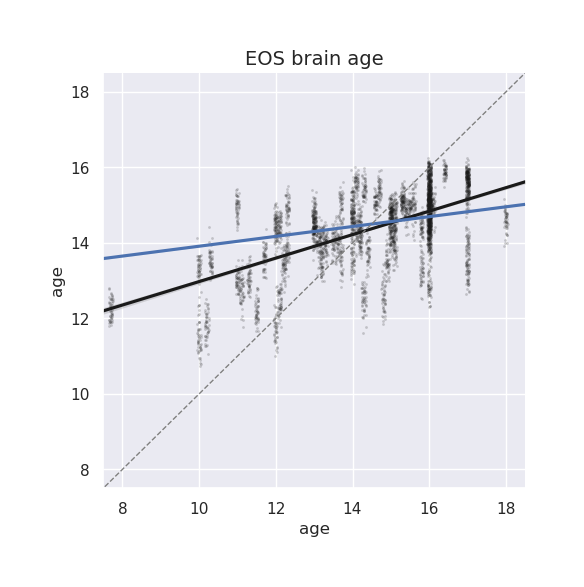

In [61]:
sns.set_theme(style="darkgrid")
model=6
all_y_pred_hc_model=all_y_pred_hc[:,model,:]
sns.set_theme(style="darkgrid")
plotdata_hc = np.zeros((all_y_pred_hc_model.shape[0]*all_y_pred_hc_model.shape[1],2))
count = 0
for i in range(y_hc.shape[0]):
    plotdata_hc[count:count+all_y_pred_hc_model.shape[0],0] = y_hc[i]
    plotdata_hc[count:count+all_y_pred_hc_model.shape[0],1] = all_y_pred_hc_model[:,i]
    count = count + all_y_pred_hc_model.shape[0]
plotdata_hc=pd.DataFrame(plotdata_hc)
plotdata_hc.rename(columns={0: 'age', 1: 'brainage'}, inplace=True) 
all_y_pred_eos_model=all_y_pred_eos[:,:,model,:]
temp=all_y_pred_eos_model.reshape(all_y_pred_eos_model.shape[0]*all_y_pred_eos_model.shape[1],all_y_pred_eos_model.shape[2])
plotdata_eos = np.zeros((temp.shape[0]*temp.shape[1],2))
count = 0
for i in range(y_eos.shape[0]):
    plotdata_eos[count:count+temp.shape[0],0] = y_eos[i]
    plotdata_eos[count:count+temp.shape[0],1] = temp[:,i]
    count = count + temp.shape[0]
plotdata_eos=pd.DataFrame(plotdata_eos)
plotdata_eos.rename(columns={0: 'age', 1: 'brainage'}, inplace=True) 

# plot brain age and actual age
g=sns.catplot(
    data=plotdata_hc, x='age', y='brainage', size=2,jitter=5,alpha=0.2,
    native_scale=True, zorder=1, color="k" ) # zorder for its priority
sns.regplot(
    data=plotdata_hc, x='age', y='brainage', ci=95, ax=g.ax,
    scatter=False, truncate=False, order=1, color="k")
g.ax.set_title('HC brain age', fontsize=14)

sns.regplot(
    data=plotdata_eos, x='age', y='brainage', ci=95, ax=g.ax,
    scatter=False, truncate=False, order=1, color="b")
sns.regplot(
    data=plotdata_eos, x='age', y='age', ci=95, ax=g.ax,
    scatter=False, truncate=False, order=1, color='grey', line_kws={"lw":1, 'linestyle':'--'})
g.ax.set_title('EOS brain age', fontsize=14)
g.ax.set_ylim(7.5, 18.5)
g.ax.set_xlim(7.5, 18.5)
#plt.savefig('/media/shuang/data/BrainAge/Glasser360/figures/REFCVRF_Brainage_MSN_o1.svg', dpi=1000)

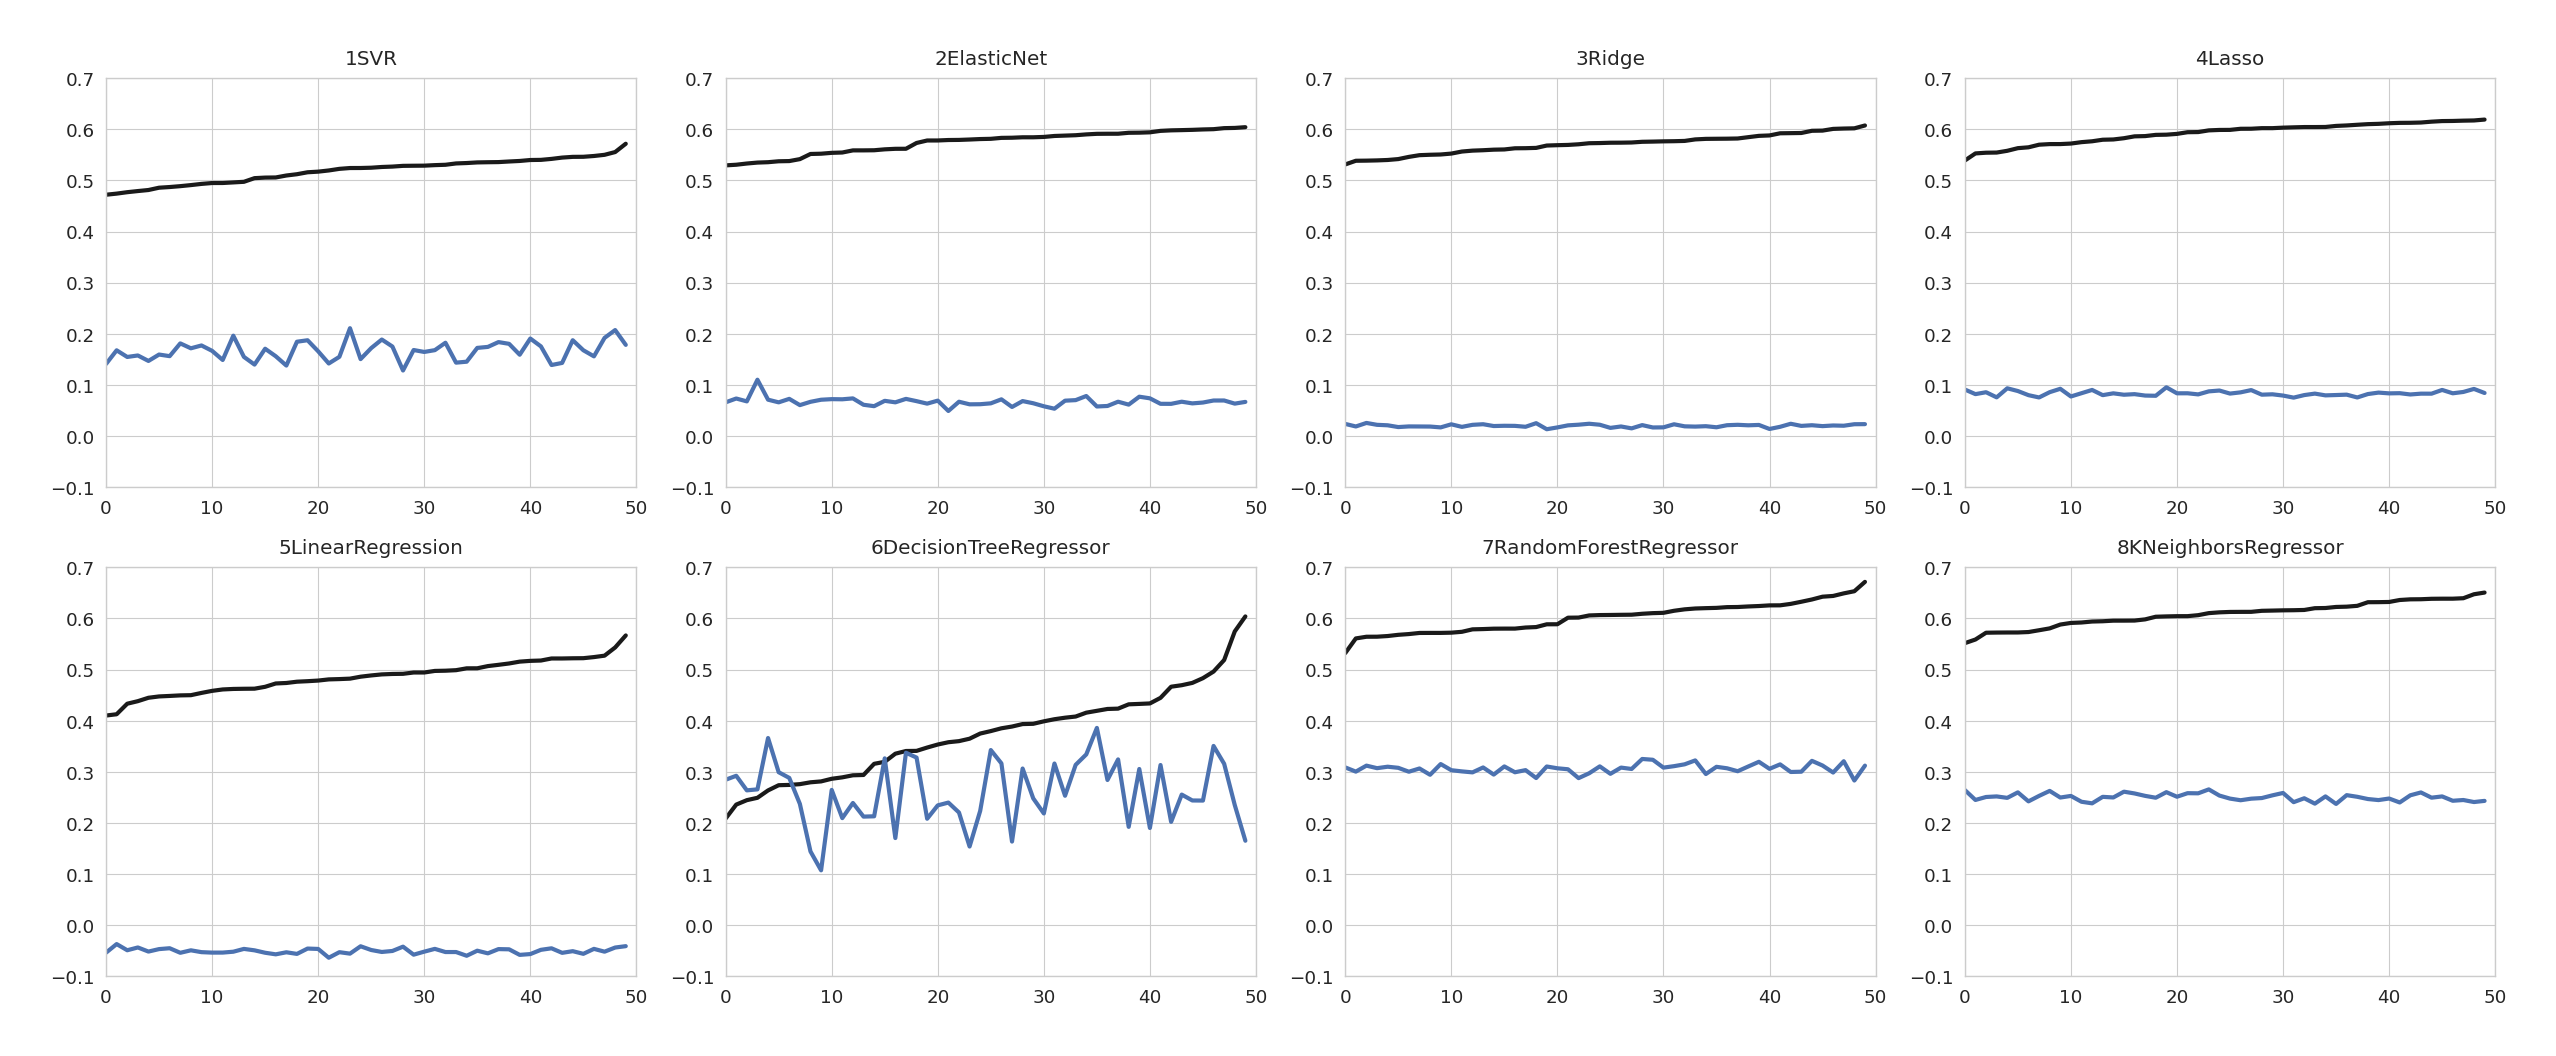

In [27]:
# show multimodal performance of Pearson r
sns.set_context("paper", font_scale = 1.5)
fig, ax = plt.subplots(2,4, figsize=(25, 10))
ax = ax.ravel()
for i in range(num_models):
    rank = HC_pearson_perm[:,0,i].argsort()
    ax[i].plot(range(50), HC_pearson_perm[:,0,i][rank], lw=3, c='k', label="HC")
    ax[i].plot(range(50), EOS_pearson_perm[:,0,i][rank], lw=3)
    ax[i].set_title(str(i+1)+modelname[i], pad=10)
    ax[i].set_xlim([0,50])
    ax[i].set_ylim([-0.1, 0.7])
fig.tight_layout()
#plt.savefig('/media/shuang/data/BrainAge/Glasser360/figures/REFCV_8modelR_MSN.svg')

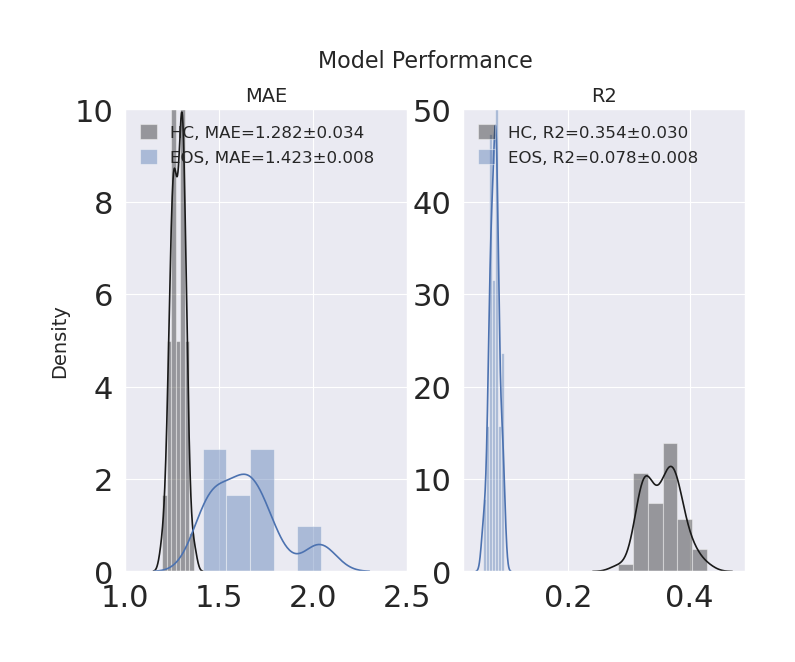

In [38]:
sns.set_context("paper", font_scale = 2.5)
nmodel=6
fig, axes = plt.subplots(1,2, figsize=(8,6))
fig.suptitle('Model Performance', fontsize=16)
sns.distplot(HC_MAE[:,nmodel], ax=axes[0],color='k', label='HC, MAE='+'%.3f'%np.nanmean(HC_MAE[:,nmodel])+'±'+'%.3f'%np.nanstd(HC_MAE[:,nmodel]))
sns.distplot(EOS_MAE[:nmodel], ax=axes[0], label='EOS, MAE='+'%.3f'%np.nanmean(EOS_MAE[:,nmodel])+'±'+'%.3f'%np.nanstd(EOS_MAE[:,nmodel]))
axes[0].legend(loc='upper left', markerscale=0.7, scatterpoints=1, fontsize=12)
axes[0].set_title('MAE', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].set_ylim(0,10)
axes[0].set_xlim(1,2.5)
sns.distplot(HC_R2[:,nmodel], ax=axes[1],color='k', label='HC, R2='+'%.3f'%np.nanmean(HC_R2[:,nmodel])+'±'+'%.3f'%np.nanstd(HC_R2[:,nmodel]))
sns.distplot(EOS_R2[:,nmodel], ax=axes[1], label='EOS, R2='+'%.3f'%np.nanmean(EOS_R2[:,nmodel])+'±'+'%.3f'%np.nanstd(EOS_R2[:,nmodel]))
axes[1].legend(loc='upper left', markerscale=0.7, scatterpoints=1, fontsize=12)
axes[1].set_ylabel('')
axes[1].set_title('R2', fontsize=14)
axes[1].set_ylim(0,50)
#plt.savefig('/media/shuang/data/BrainAge/Glasser360/figures/REFCVRF_MAE_MSN.svg', dpi=1000, transparent=True)
plt.show()